In [2]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

ImportError: cannot import name 'gaussian' from 'scipy.signal' (/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/scipy/signal/__init__.py)

In [ ]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56244,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56261,Total threads: 2
Dashboard: http://127.0.0.1:56266/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:56247,


In [ ]:
# Import config for centralized path management
from aislens.config import config

# Note: All file paths are now managed through config
# Access paths like: config.FILE_MPASO_MODEL, config.DIR_PROCESSED, etc.

In [ ]:
yr1 = 300
yr2 = 900

# Load ocean model data using config paths
SORRMv21 = xr.open_dataset(config.FILE_MPASO_MODEL, chunks={"Time":36})
SORRMv21_flux = SORRMv21[config.SORRM_FLUX_VAR][yr1*12:yr2*12]
SORRMv21_draft = SORRMv21[config.SORRM_DRAFT_VAR]

In [ ]:
# Config already imported in cell 3
# from aislens.config import config

In [ ]:
# Load ice shelf masks using config
ICESHELVES_MASK = gpd.read_file(config.FILE_ICESHELFMASKS)
icems = ICESHELVES_MASK.to_crs(config.CRS_TARGET)
crs = ccrs.SouthPolarStereo()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
SORRMv21_flux_ts_integrated = SORRMv21_flux.sum(dim=['x', 'y']).compute()

In [9]:
# Resample SORRMv21_flux_ts to annual
SORRMv21_flux_ts_annual = SORRMv21_flux_ts.resample(Time='A').mean().compute()

# DESEASONALIZED BY RESAMPLING TO ANNUAL


# DETREND


In [56]:
SORRMv21_flux_ts_annual_detrend = detrend_dim(SORRMv21_flux_ts_annual, 'Time', 1)

In [ ]:
# Load observational data using config
obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(
    config.DIR_PROCESSED / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", 
    chunks={"x":729, "y":729}
)

MELTDRAFT_OBS = xr.open_dataset(config.FILE_PAOLO23_SATOBS, chunks={"x":729, "y":729})
obs23_melt = MELTDRAFT_OBS[config.SATOBS_FLUX_VAR]
obs23_draft = MELTDRAFT_OBS[config.SATOBS_DRAFT_VAR]

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Mean ice shelf basal melt rate from satellite observations (1992-2017)')

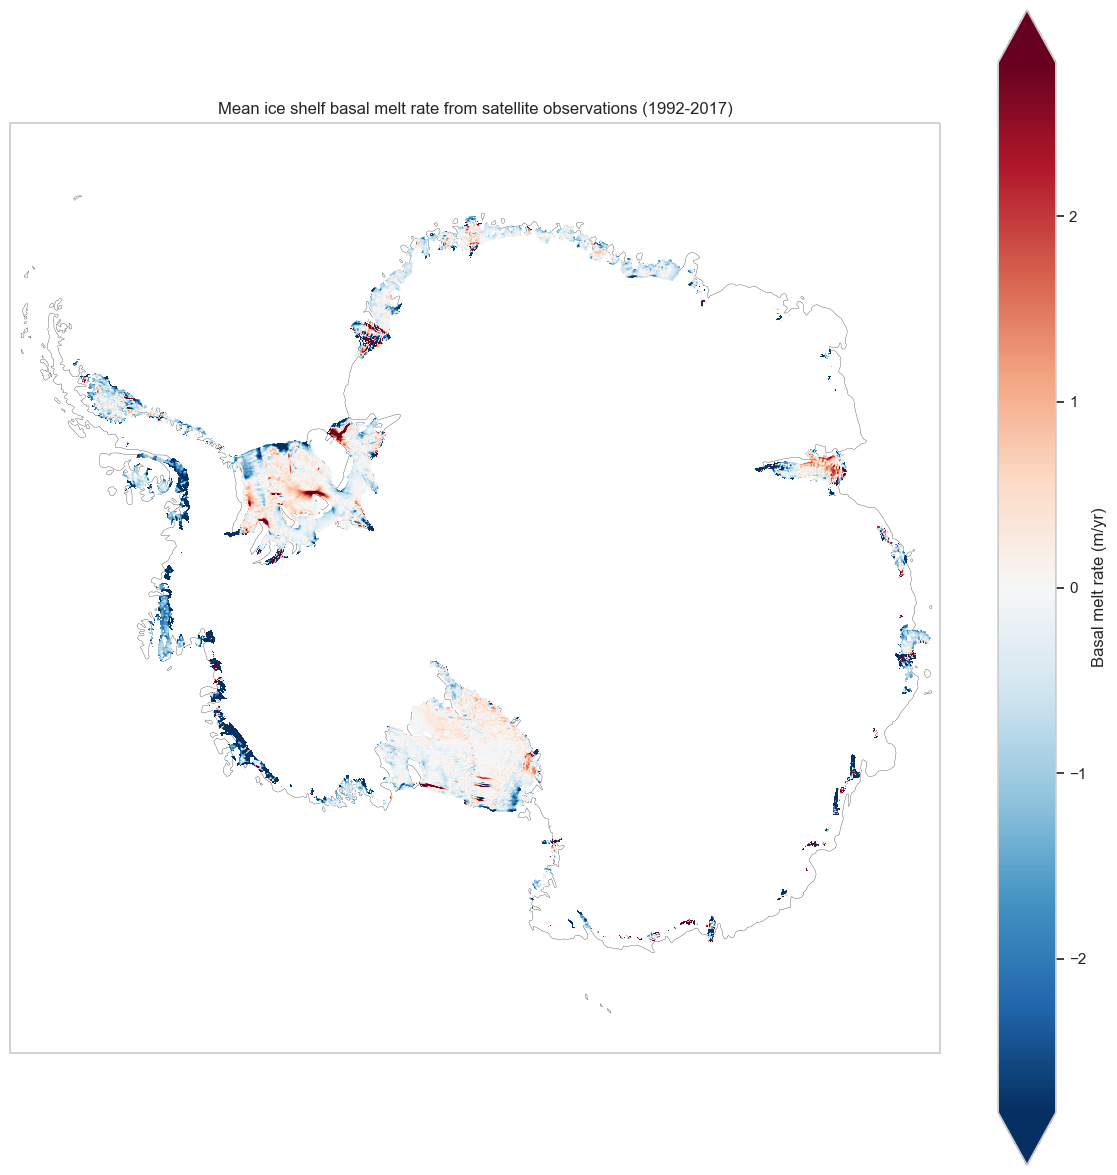

In [65]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

Text(0.5, 1.0, 'MPAS-Ocean Freshwater Flux over a select 300 years in a 1000 year simulation')

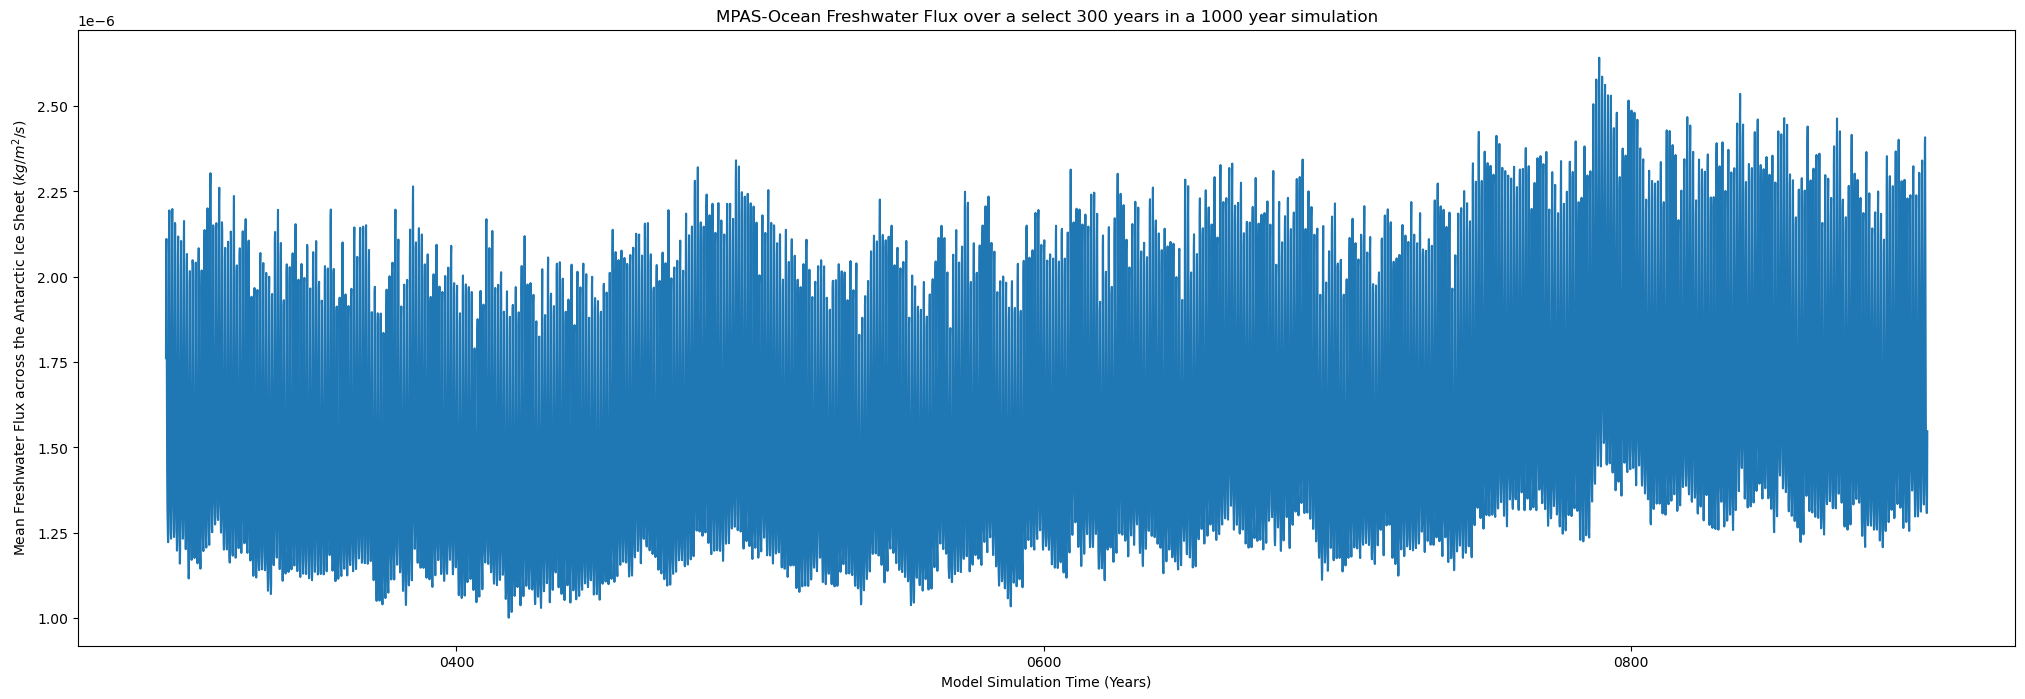

In [63]:
plt.figure(figsize=(25,8))
SORRMv21_flux_ts.plot()
plt.xlabel("Model Simulation Time (Years)")
plt.ylabel("Mean Freshwater Flux across the Antarctic Ice Sheet ($kg/m^2/s$)")
plt.title("MPAS-Ocean Freshwater Flux over a select 300 years in a 1000 year simulation")

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_80188/2483409575.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121, projection=ccrs.SouthPolarStereo())


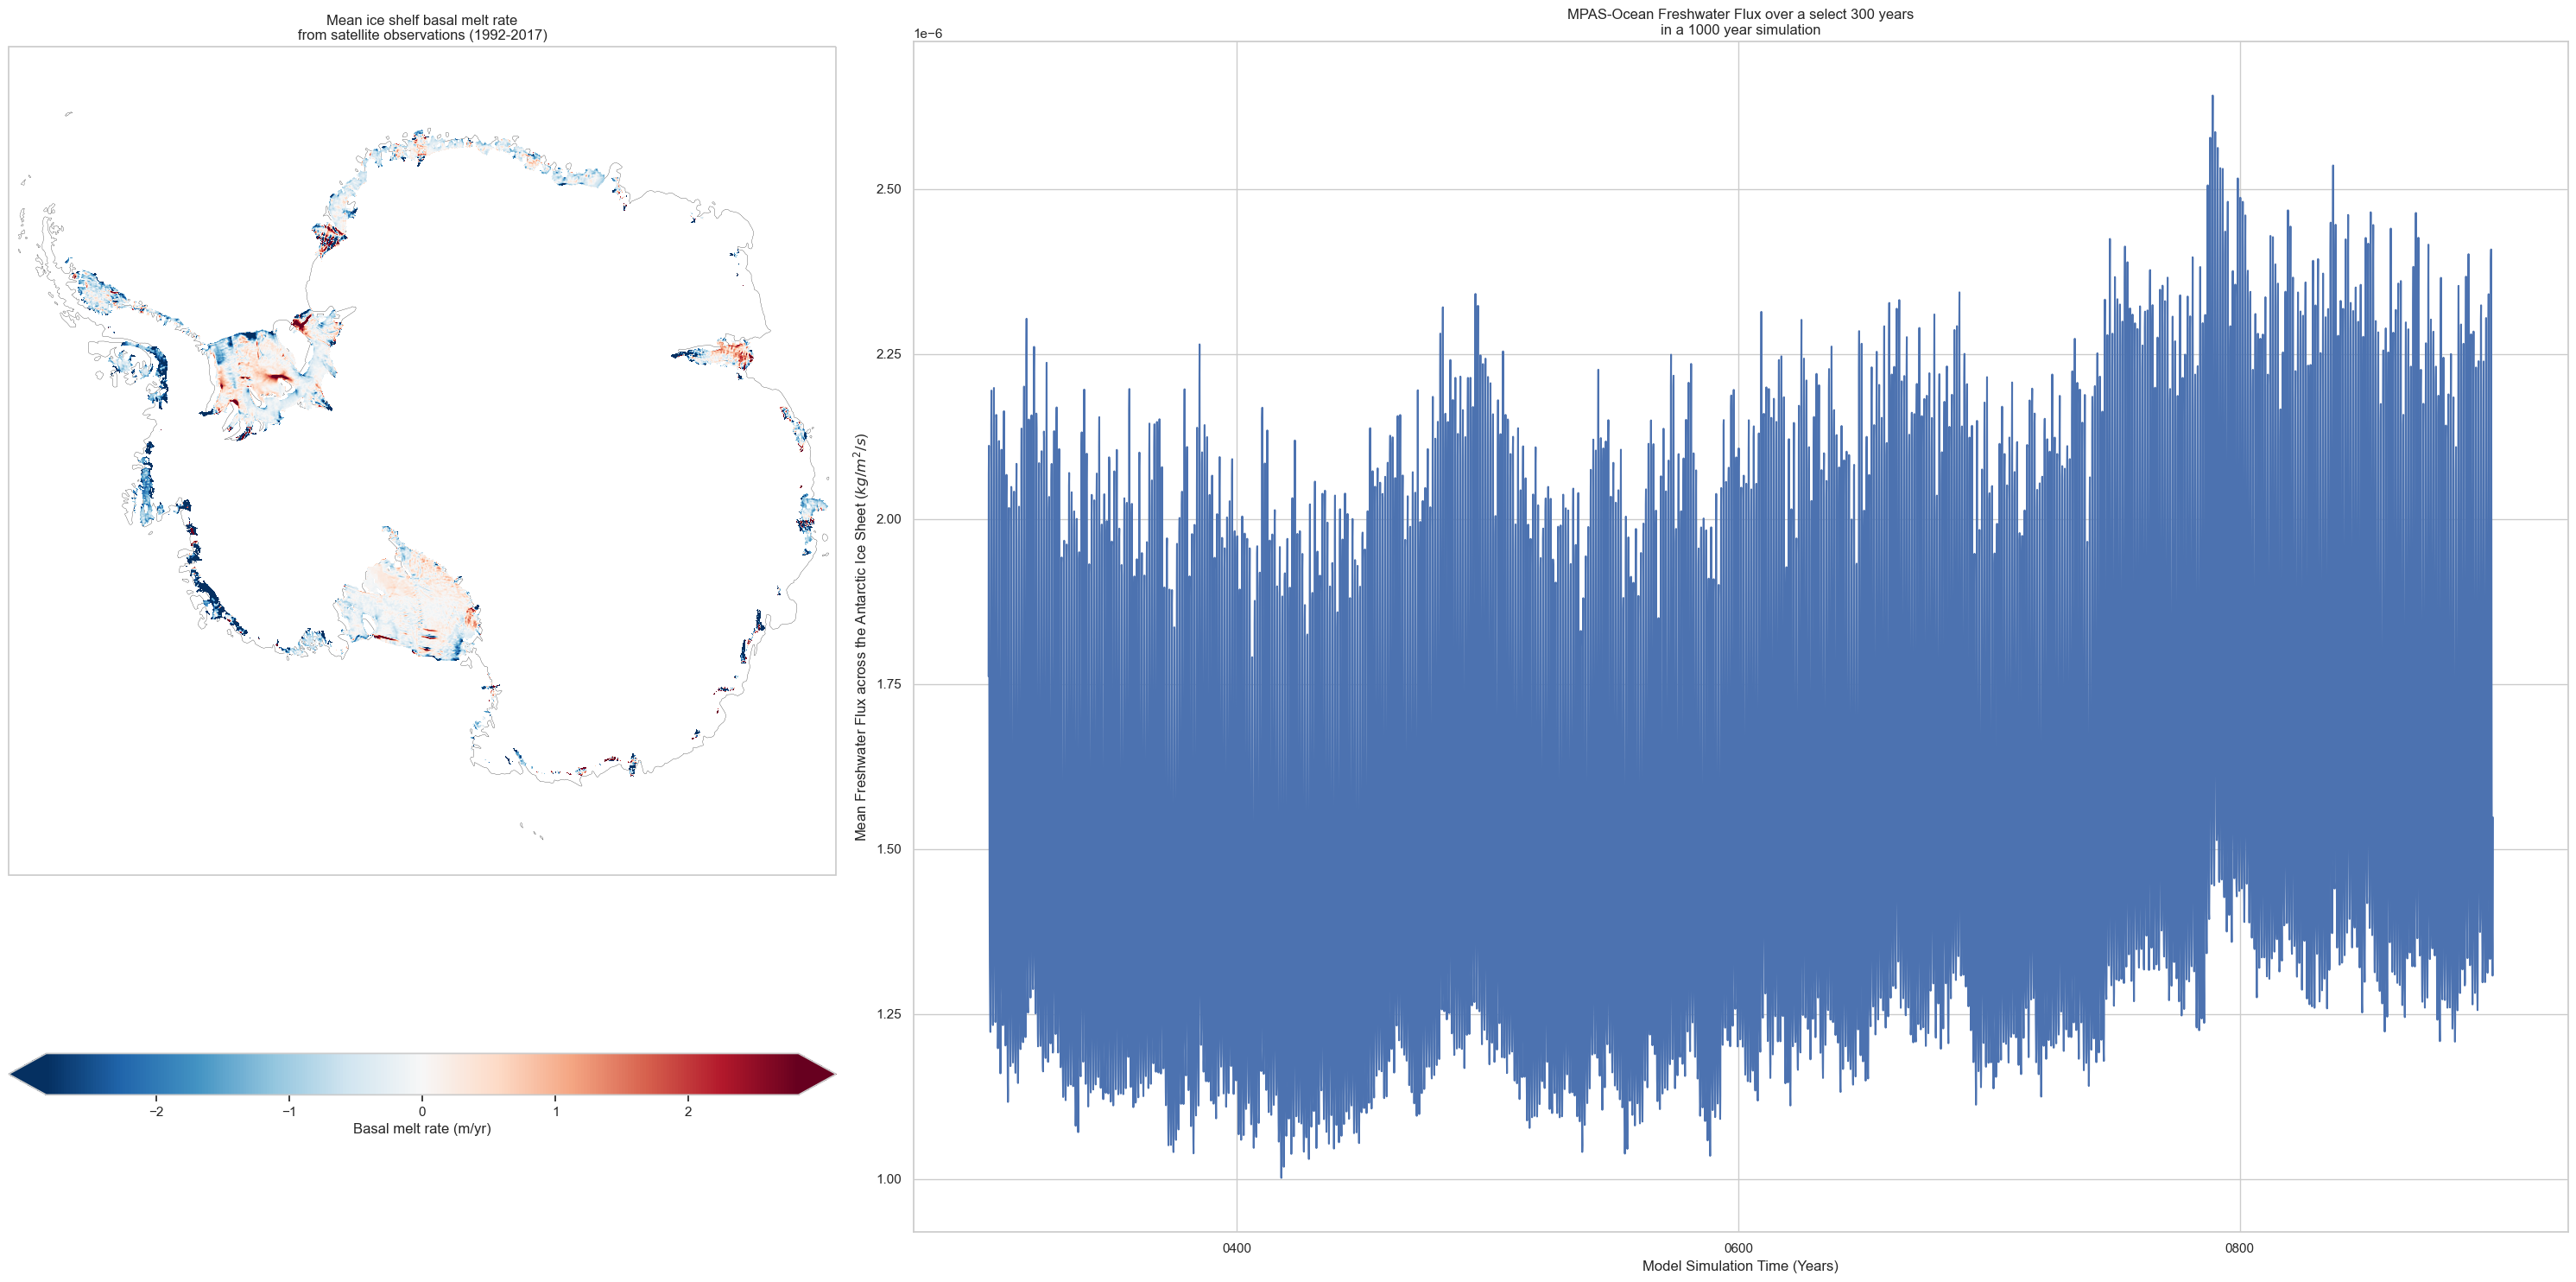

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

# Set the overall figure size and create subplots with custom widths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), 
                               gridspec_kw={'width_ratios': [1, 2]})

# Left plot (Antarctic map)
ax1 = plt.subplot(121, projection=ccrs.SouthPolarStereo())

ax1.coastlines(lw=0.2)

obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, 
                   cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)', "location": "bottom"}, zorder=5)
ax1.set_title('Mean ice shelf basal melt rate\nfrom satellite observations (1992-2017)')

# Right plot (Time series)
SORRMv21_flux_ts.plot(ax=ax2)
ax2.set_xlabel("Model Simulation Time (Years)")
ax2.set_ylabel("Mean Freshwater Flux across the Antarctic Ice Sheet ($kg/m^2/s$)")
ax2.set_title("MPAS-Ocean Freshwater Flux over a select 300 years\nin a 1000 year simulation")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# SATELLITE OBSERVATIONS

obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(
    config.DIR_PROCESSED / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", 
    chunks={"x":729, "y":729}
)

MELTDRAFT_OBS = xr.open_dataset(config.FILE_PAOLO23_SATOBS, chunks={"x":729, "y":729})
obs23_melt = MELTDRAFT_OBS[config.SATOBS_FLUX_VAR]
obs23_draft = MELTDRAFT_OBS[config.SATOBS_DRAFT_VAR]

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_80188/1266967339.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


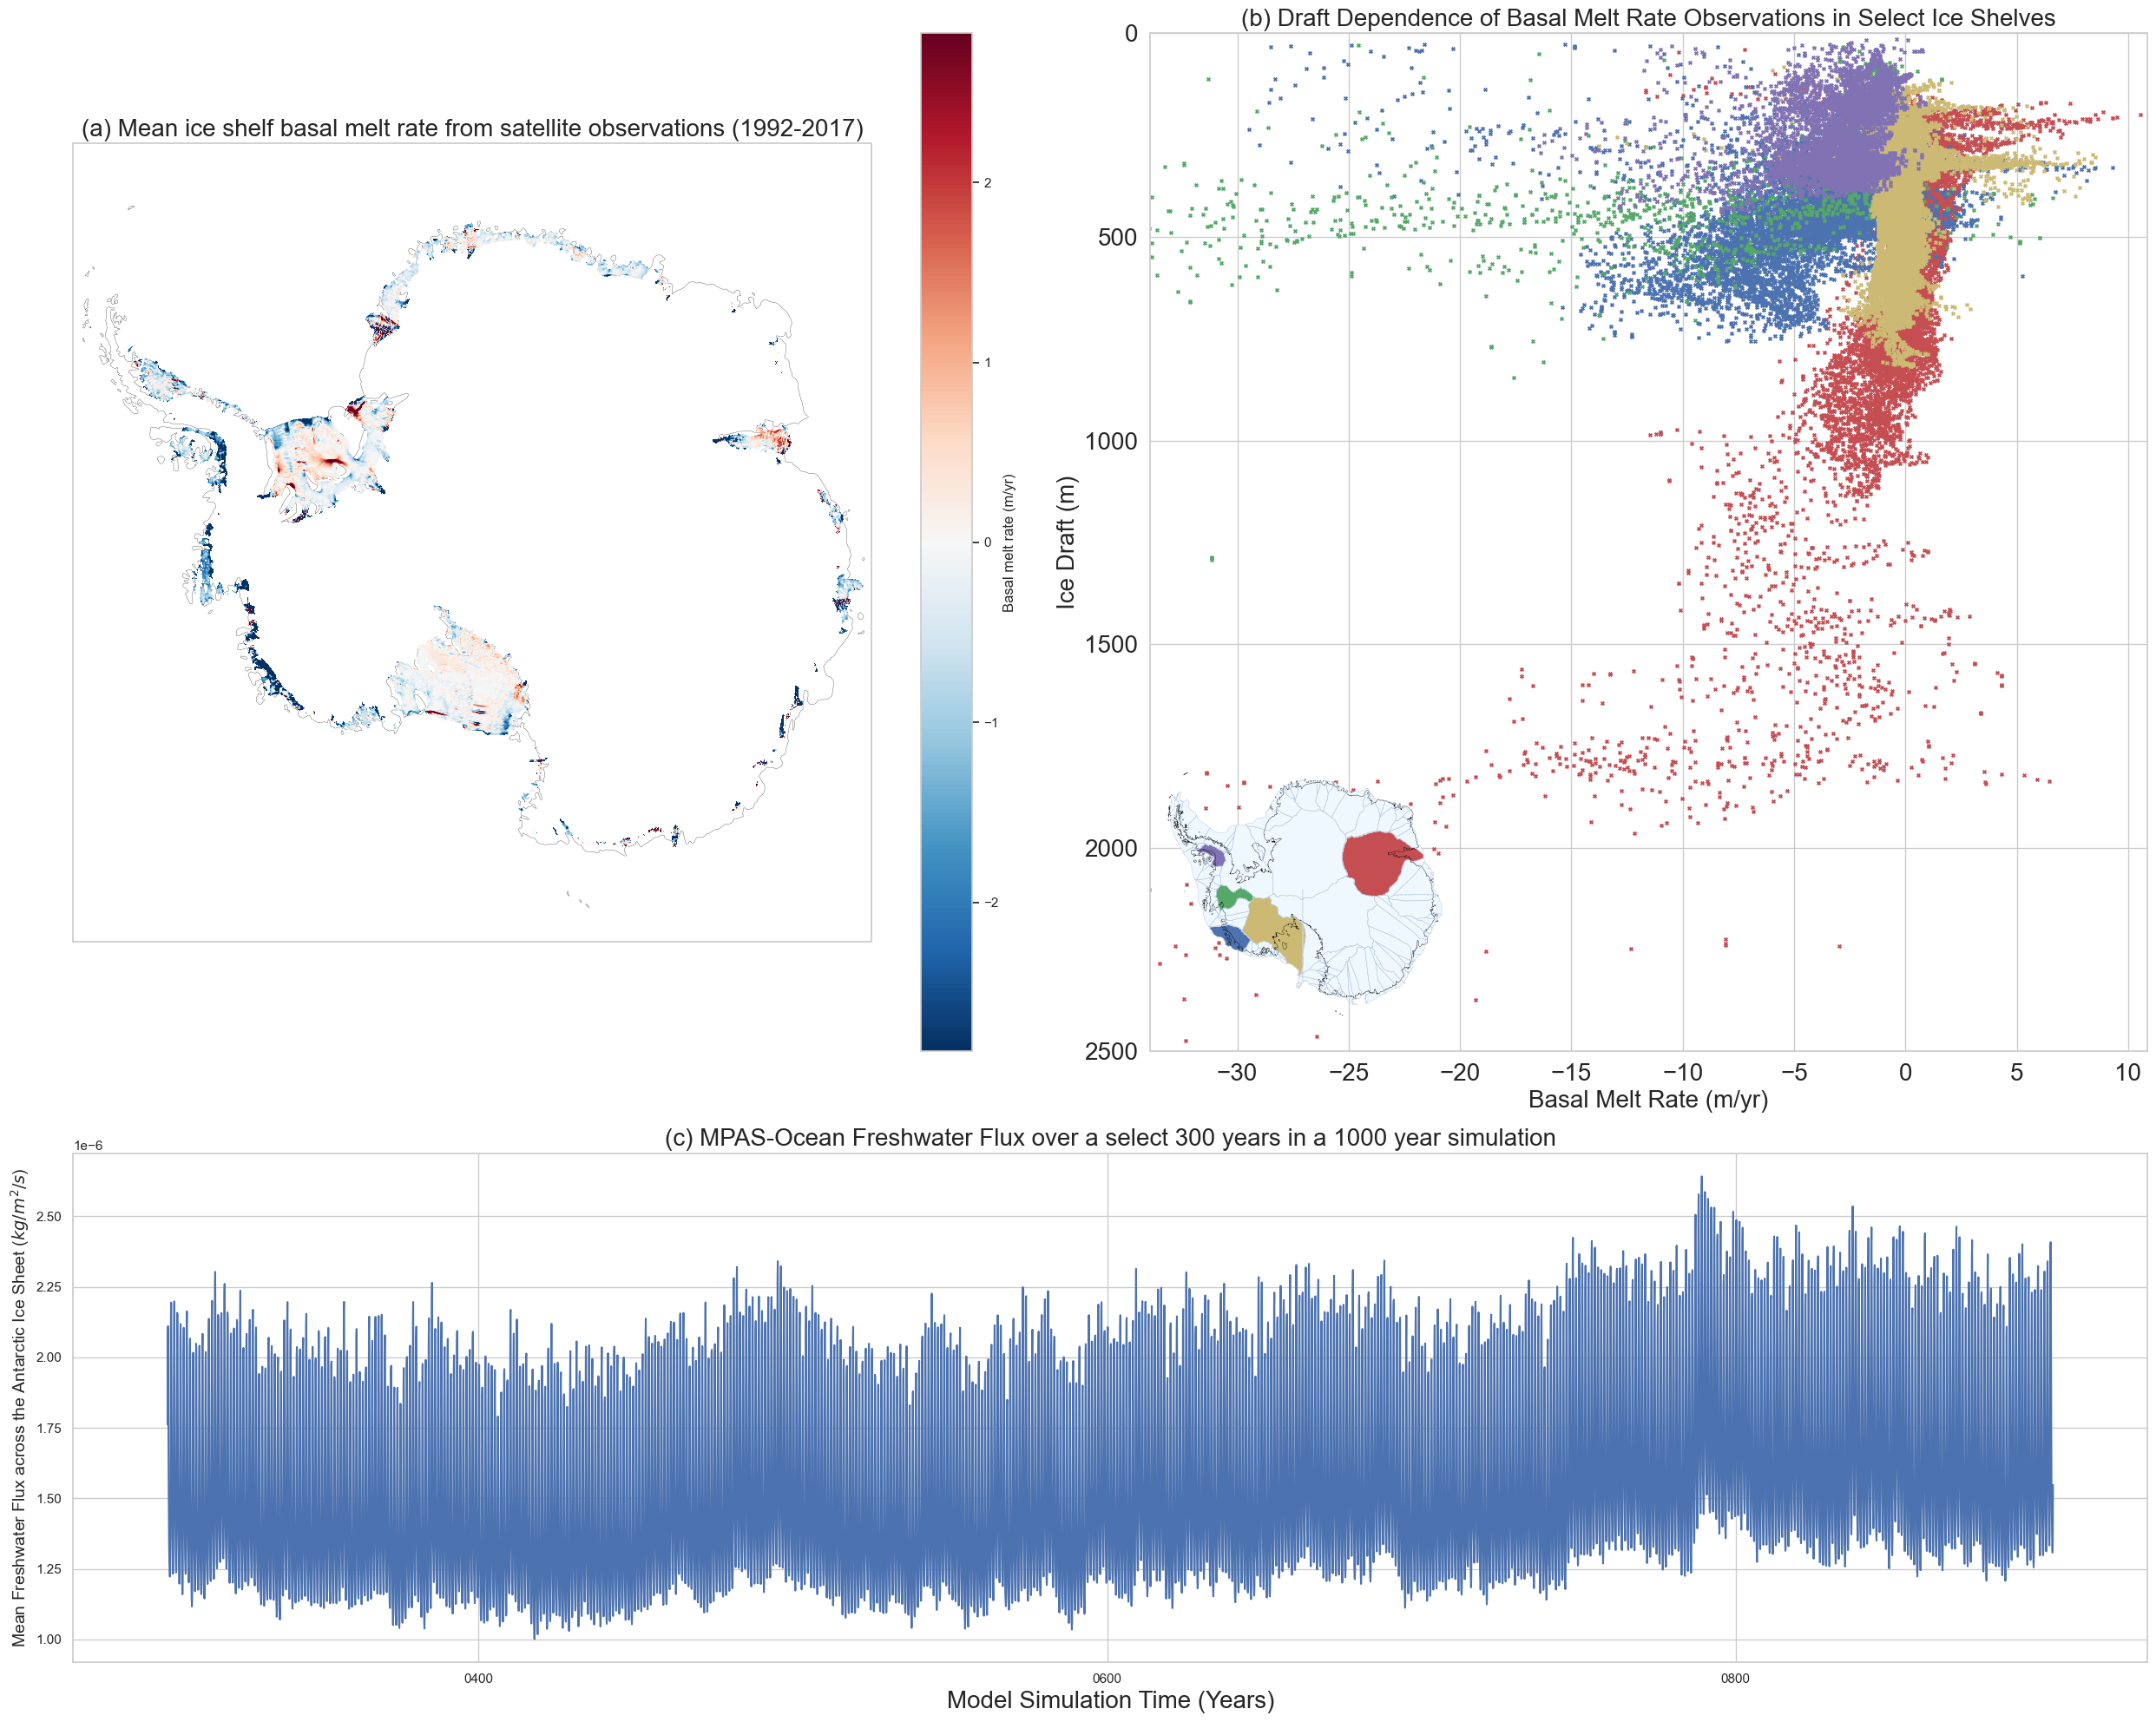

2024-08-16 09:50:36,677 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 34 MB fds: 216>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 34 MB fds: 216>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.

In [115]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

font_size = 20
plt.rcParams.update({'font.size': 20})

# Set up the figure with a 2x2 grid
fig = plt.figure(figsize=(25, 20))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5])

# Plot 1 (top left)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.SouthPolarStereo())
sns.set_theme(style="whitegrid")

ax1.coastlines(lw=0.2)
obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', 
                   cbar_kwargs={'label': 'Basal melt rate (m/yr)', 'extend': 'neither'}, zorder=5)
ax1.set_title('(a) Mean ice shelf basal melt rate from satellite observations (1992-2017)', fontsize=font_size)

# Plot 2 (top right)
ax2 = fig.add_subplot(gs[0, 1])
ice_shelves_for_figure = ['Amery', 'Getz', 'Pine_Island', 'Eastern_Ross', 'George_VI']
colors=['r', 'b', 'g', 'y', 'm']

for index, shelfname in enumerate(ice_shelves_for_figure):
    i = find_ice_shelf_index(shelfname)
    mlt = clip_data(obs23_melt_tm, i)
    h = clip_data(obs23_draft_tm, i)
    
    mlt_stack = mlt.stack(z=('x', 'y'))
    h_stack = h.stack(z=('x', 'y'))
    
    mlt_stack_noNaN = mlt_stack.fillna(0)
    h_stack_noNaN = h_stack.fillna(0)
    
    mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
    h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)
    
    X = h_stack_noNaN_vals
    y = mlt_stack_noNaN_vals
    reg = LinearRegression().fit(X,y)
    
    ax2.scatter(mlt, h, alpha=1, s=7, label=shelfname, marker='x', color=colors[index])

ax2.set_ylim(2500, 0)
ax2.set_xlim(obs23_melt_tm_vmin*3,obs23_melt_tm_vmax*3)
ax2.set_xlabel('Basal Melt Rate (m/yr)', fontsize=font_size)
ax2.set_ylabel('Ice Draft (m)', fontsize=font_size)
ax2.set_title('(b) Draft Dependence of Basal Melt Rate Observations in Select Ice Shelves', fontsize=font_size)
# ax2.legend(loc='lower left')
ax2.tick_params(axis='both', which='major', labelsize=font_size)


# Add inset map
axins = inset_axes(ax2, width="30%", height="30%", loc="lower left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[33:133].plot(ax=axins, linewidth=0.3, color='aliceblue')
icems[33:133].boundary.plot(ax=axins, linewidth=0.3, color='lightsteelblue')
axins.coastlines(resolution='10m', linewidth=0.25)
axins.set_axis_off()
for index, shelfname in enumerate(ice_shelves_for_figure):
    i = find_ice_shelf_index(shelfname)
    icems.loc[[i],'geometry'].plot(ax=axins,color=colors[index],linewidth=0.4)


# Plot 3 (bottom, spanning both columns)
ax3 = fig.add_subplot(gs[1, :])
SORRMv21_flux_ts.plot(ax=ax3)
ax3.set_xlabel("Model Simulation Time (Years)", fontsize=font_size)
ax3.set_ylabel("Mean Freshwater Flux across the Antarctic Ice Sheet ($kg/m^2/s$)", fontsize=14)
ax3.set_title("(c) MPAS-Ocean Freshwater Flux over a select 300 years in a 1000 year simulation", fontsize=font_size)
ax2.tick_params(axis='both', which='major', labelsize=font_size)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [13]:
vmin_flux = np.nanquantile(detrend_deseasonalize_flux.values, 0.01)
vmax_flux = np.nanquantile(detrend_deseasonalize_flux.values, 0.99)

2024-05-30 13:04:17,818 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.06 GiB -- Worker memory limit: 3.20 GiB
2024-05-30 13:04:18,210 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.27 GiB -- Worker memory limit: 3.20 GiB


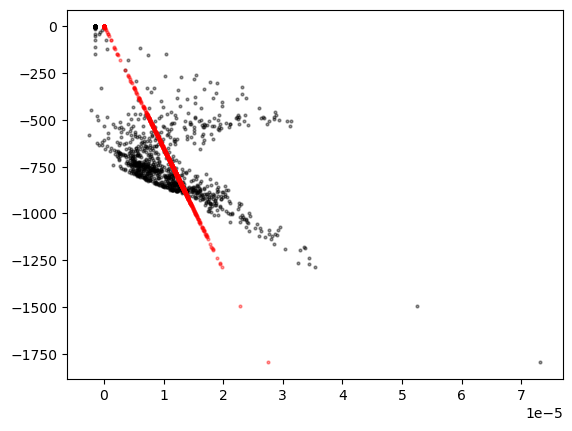

In [25]:
plt.scatter(mlt_tm, h_tm, color='black', alpha=0.4, s=4)
plt.scatter(mlt_pred, h_tm, color='red', alpha=0.4, s=4)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(SORRMv21_flux_ts);
axs[0].psd(SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Freshwater Flux')

SORRMv21_flux_ts.plot(ax=axs[1], label='raw-ocean-model-output')
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-ocean-model-output')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Freshwater Flux')

plt.legend()
fig.suptitle('Spatially Averaged Basal Freshwater Flux Time Series and Power Spectral Density')
plt.show()

# Dedraft

In [ ]:
iceShelfRegions = config.ICE_SHELF_REGIONS

def dedraft(data, draft):
    data_tm = data.mean(dim='Time')
    draft_tm = draft.mean(dim='Time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    #data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    #data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    #data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    #data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_#, data_pred, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(SORRMv21_flux_detrend_uniform_deseasonalize_uniform, i)
    h = clip_data(SORRMv21_draft, i)
    mlt_tm = mlt.mean(dim='Time')
    h_tm = h.mean(dim='Time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_coef, mlt_intercept = dedraft(mlt, h)

    mlt_coef_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_coef)
    mlt_intercept_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_intercept)
    mlt_coef_ds = xr.DataArray(mlt_coef_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_intercept_ds = xr.DataArray(mlt_intercept_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_coef_ds.rio.write_crs(config.CRS_TARGET, inplace=True)
    mlt_intercept_ds.rio.write_crs(config.CRS_TARGET, inplace=True)
    
    # Create a boolean mask for the ice shelf of interest using the icems geometry
    ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)
    
    # Filter the data arrays using this mask
    mlt_coef_ds = mlt_coef_ds.rio.clip(ice_shelf_mask, icems.crs)
    mlt_intercept_ds = mlt_intercept_ds.rio.clip(ice_shelf_mask, icems.crs)
    
    mlt_coef_ds.name = 'draftDepenBasalMeltAlpha1'
    mlt_coef_ds.attrs['long_name'] = 'Freshwater flux draft dependency coefficient (alpha1 or slope)'
    mlt_coef_ds.attrs['units'] = 'kg/m^3/s'

    mlt_intercept_ds.name = 'draftDepenBasalMeltAlpha0'
    mlt_intercept_ds.attrs['long_name'] = 'Freshwater flux draft dependency coefficient (alpha0 or intercept)'
    mlt_intercept_ds.attrs['units'] = 'kg/m^2/s'
    
    # Save data arrays to a single xarray dataset
    mlt_coefs = xr.Dataset({'draftDepenBasalMeltAlpha1': mlt_coef_ds, 'draftDepenBasalMeltAlpha0': mlt_intercept_ds})

    # Use config for output path
    output_file = config.DIR_ICESHELF_DEDRAFT_MODEL / f'draftDepenBasalMeltAlpha_{icems.name.values[i]}.nc'
    output_file.parent.mkdir(parents=True, exist_ok=True)
    mlt_coefs.to_netcdf(output_file)
    
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_coef, mlt_intercept, mlt_coef_ds, mlt_intercept_ds, ice_shelf_mask, mlt_coefs
    print('deleted interim variables')
    gc.collect()

In [ ]:
SORRMv21_flux_detrend_uniform_deseasonalize_uniform.rio.write_crs(config.CRS_TARGET, inplace=True)
SORRMv21_draft.rio.write_crs(config.CRS_TARGET, inplace=True)

In [ ]:
iceShelfRegions = config.ICE_SHELF_REGIONS

def dedraft(data, draft):
    data_tm = data.mean(dim='Time')
    draft_tm = draft.mean(dim='Time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred_tmp = data_pred_stack.unstack('z').transpose()
    data_pred = xr.DataArray(np.full((data.shape[1], data.shape[2]), np.nan), dims=['y', 'x'], coords={'x': data.x, 'y': data.y})
    data_pred.loc[{'x': data.x, 'y': data.y}] = data_pred_tmp
    #data_dedraft = data - data_pred
    return data_pred#, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(SORRMv21_flux_detrend_uniform_deseasonalize_uniform, i)
    h = clip_data(SORRMv21_draft, i)
    mlt_tm = mlt.mean(dim='Time')
    h_tm = h.mean(dim='Time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_pred = dedraft(mlt, h)

    mlt_pred.name = 'draftDepenBasalMeltPred'
    
    # Use config for output path
    output_file = config.DIR_ICESHELF_DEDRAFT_MODEL / "pred" / f'draftDepenBasalMeltPred_{icems.name.values[i]}.nc'
    output_file.parent.mkdir(parents=True, exist_ok=True)
    mlt_pred.to_netcdf(output_file)

    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_pred
    print('deleted interim variables')
    gc.collect()

In [ ]:
# Merge draft dependence parameters for all ice shelves into a single xarray dataset

iceShelfRegions = config.ICE_SHELF_REGIONS
ds = xr.Dataset()

for i in iceShelfRegions:
    param_file = config.DIR_ICESHELF_DEDRAFT_MODEL / f'draftDepenBasalMeltAlpha_{icems.name.values[i]}.nc'
    ds = xr.merge([ds, xr.open_dataset(param_file)])

# Save merged parameters
output_file = config.DIR_DRAFT_DEPENDENCE / 'draftDepenBasalMeltAlpha.nc'
output_file.parent.mkdir(parents=True, exist_ok=True)
ds.to_netcdf(output_file)

In [ ]:
flux_dedraft = SORRMv21_flux_detrend_uniform_deseasonalize_uniform - tmp_ds

In [ ]:
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot()
plt.axhline(tmp_ds.mean())

In [ ]:
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts = SORRMv21_flux_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

In [ ]:
flux_dedraft_ts = flux_dedraft.mean(dim=['x', 'y']).compute()

In [ ]:
# Save dedrafted flux using config path
output_file = config.DIR_PROCESSED / "SORRMv21_flux_detrend_uniform_deseasonalize_uniform_dedraft.nc"
flux_dedraft.to_netcdf(output_file, engine='h5netcdf')

In [ ]:
fl = flux_dedraft[0:3600]

In [ ]:
vmin_fl = np.nanquantile(fl.values, 0.01)

In [ ]:
vmax_fl = np.nanquantile(fl.values, 0.99)

In [87]:
anm_annual = anm[0:600].resample(Time='AS').mean().compute()

2024-05-30 13:59:21,247 - distributed.worker - ERROR - Exception during execution of task ('mean_chunk-12c78f3d4abb18d8e7eba3d1f267a521', 39, 0, 0).
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/worker.py", line 2364, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/spill.py", line 257, in __getitem__
    return super().__getitem__(key)
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: "('getitem-mean_chunk-12c78f3d4abb18d8e7eba3d1f267a521', 39, 0, 0)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/worker.py", line 2246, in execute
    args2, kwargs2 =

In [ ]:
output_file = config.DIR_PROCESSED / "SORRMv21_flux_detrend_uniform_deseasonalize_uniform_dedraft_anm_annual_50.nc"
anm_annual.to_netcdf(output_file, engine='h5netcdf')

In [ ]:
anm_annual = xr.open_dataset(
    config.DIR_PROCESSED / "SORRMv21_flux_detrend_uniform_deseasonalize_uniform_dedraft_anm_annual_50.nc", 
    chunks={"Time":36}
)
anm_annual = anm_annual.__xarray_dataarray_variable__

In [11]:
x = anm_annual.x
y = anm_annual.y

In [9]:
anm_annual

<xarray.DataArray '__xarray_dataarray_variable__' (Time: 50, y: 601, x: 601)>
dask.array<open_dataset-9537fe13491c0c3c45b01d8b3b7cf3e8__xarray_dataarray_variable__, shape=(50, 601, 601), dtype=float64, chunksize=(36, 601, 601), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * y        (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
    lat      (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
  * Time     (Time) object 0301-01-01 00:00:00 ... 0350-01-01 00:00:00

In [12]:
valid_idx = ~np.isnan(anm_annual[0].values)

In [39]:
grid_x, grid_y = np.meshgrid(np.unique(x), np.unique(y))

In [45]:
obs_x = grid_x[valid_idx]
obs_y = grid_y[valid_idx]

In [48]:
from scipy.interpolate import griddata
interpolated_melt = griddata((x, y), observed_anm, (grid_x, grid_y), method='idw')


ValueError: Unknown interpolation method 'idw' for 2 dimensional data

In [27]:
observed_anm = anm_annual[:].where(valid_idx)

In [ ]:
anm_annual.rio.write_crs(config.CRS_TARGET, inplace=True)

In [12]:
ice_shelf_name = 'Filchner'
i = find_ice_shelf_index(ice_shelf_name)

anm_is = clip_data(anm_annual, i)

In [14]:
anm_is_slice = anm_is[0]

(185, 203)

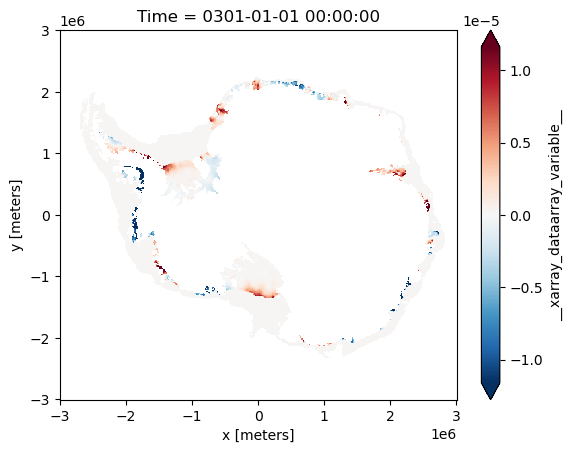

In [90]:
anm_annual[0].plot(vmin=-vmax_anm, vmax=vmax_anm, cmap='RdBu_r')

In [93]:
anm_annual_ts = anm_annual.mean(dim=['x', 'y']).compute()

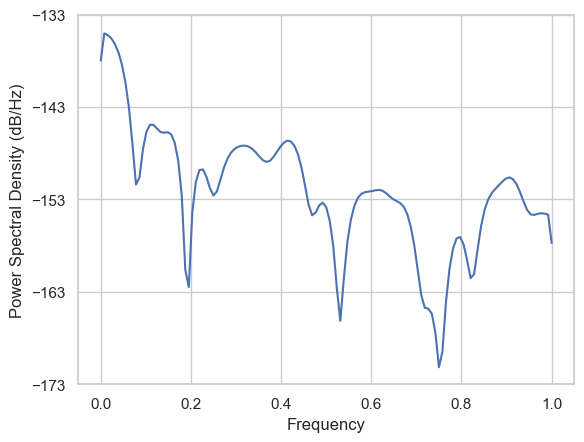

In [95]:
plt.psd(anm_annual_ts);

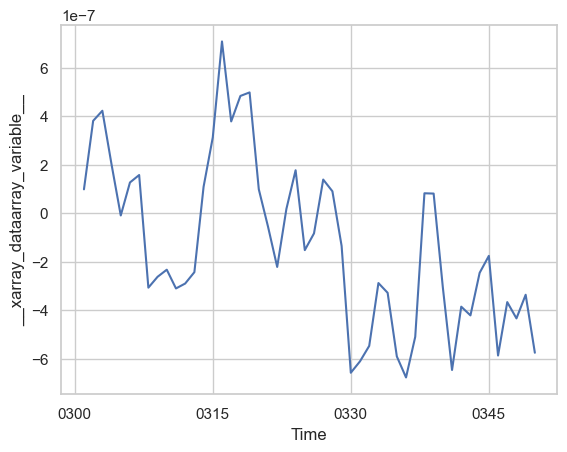

In [96]:
anm_annual_ts.plot()

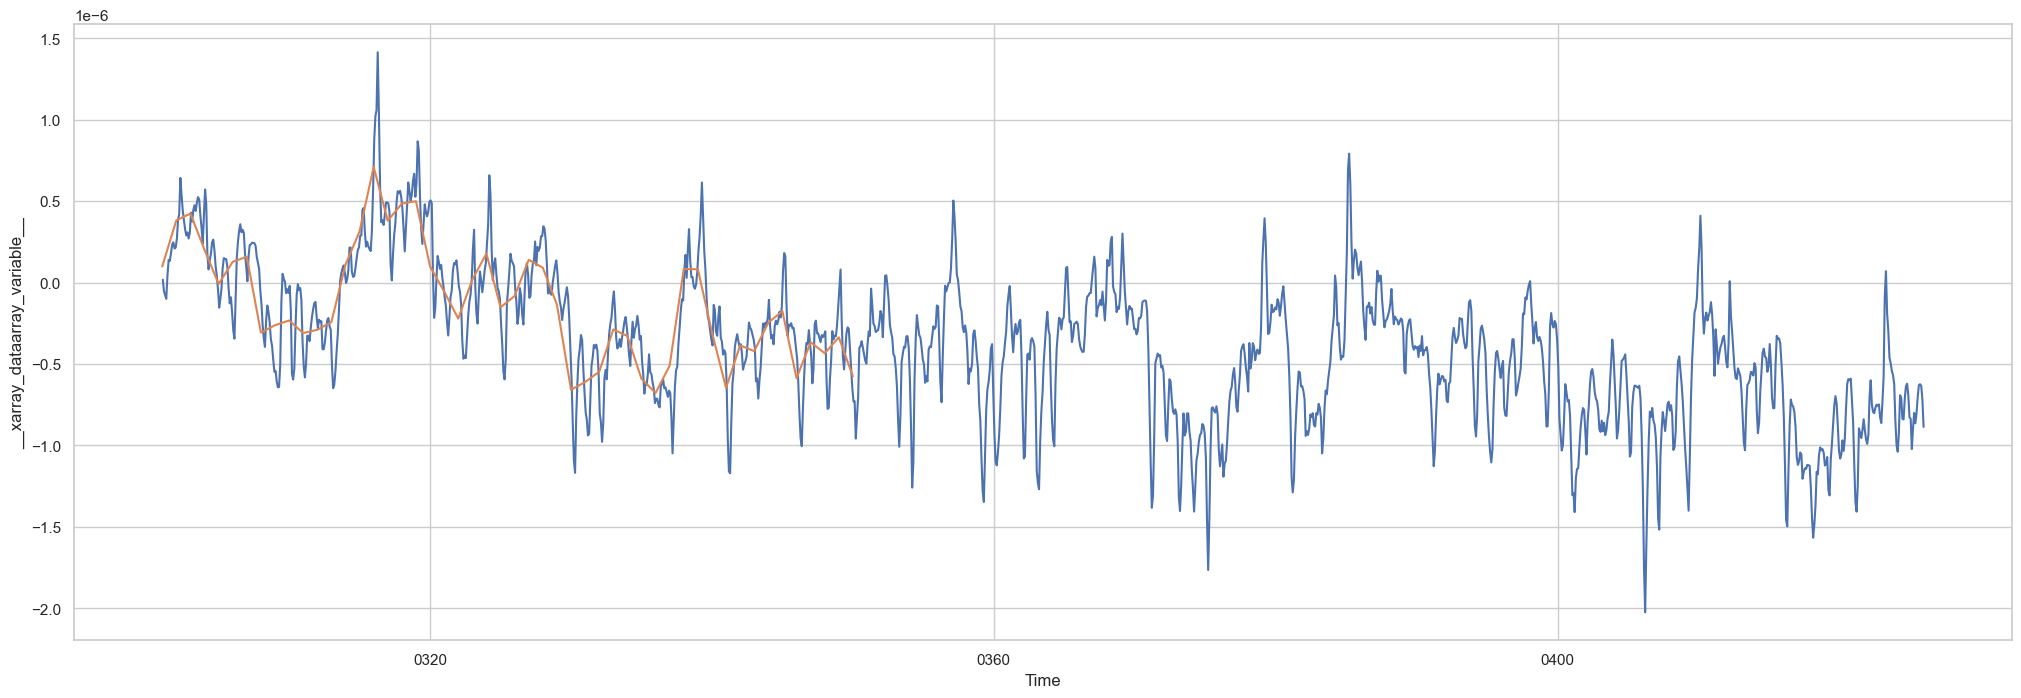

In [101]:
plt.figure(figsize=(25,8))
anm_ts[:1500].plot()
anm_annual_ts.plot()

In [ ]:
# Plot figure

sns.set_theme(style="whitegrid")

# Use config for output directory
output_dir = config.DIR_PROCESSED / 'figures/annual'
output_dir.mkdir(parents=True, exist_ok=True)

for i in range(0,50):
    plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
    ax1.coastlines(lw=0.2)
    anm_annual[i].plot(ax=ax1, vmin=-vmax_anm, vmax=vmax_anm, cmap='RdBu_r', cbar_kwargs={'label': 'Freshwater flux variability (kg/m2/s)'}, zorder=5)
    plt.title('Freshwater flux internal variability (kg/m2/s), Time: {}'.format(anm_annual.Time.values[i]))
    plt.savefig(output_dir / f'SORRMv21_variability_annual_{i}.png', dpi=300, bbox_inches='tight')
    plt.close()

Task exception was never retrieved
future: <Task finished name='Task-1428772' coro=<Client._gather.<locals>.wait() done, defined at /Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/client.py:2141> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/client.py", line 2150, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1428773' coro=<Client._gather.<locals>.wait() done, defined at /Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/client.py:2141> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/client.py", line 2150, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1428774' co

In [ ]:
# Plot figure

sns.set_theme(style="whitegrid")

# Use config for output directory
output_dir = config.DIR_PROCESSED / 'figures'
output_dir.mkdir(parents=True, exist_ok=True)

for i in range(0,3600):
    plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
    ax1.coastlines(lw=0.2)
    fl[i].plot(ax=ax1, vmin=-vmax_fl, vmax=vmax_fl, cmap='RdBu_r', cbar_kwargs={'label': 'Freshwater flux variability (kg/m2/s)'}, zorder=5)
    plt.title('Freshwater flux internal variability (kg/m2/s), Time: {}'.format(fl.Time.values[i]))
    plt.savefig(output_dir / f'SORRMv21_variability_{i}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
sns.set_theme(style="whitegrid")

i=100
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax1.coastlines(lw=0.2)
fl[i].plot(ax=ax1, vmin=-vmax_fl, vmax=vmax_fl, cmap='RdBu_r', cbar_kwargs={'label': 'Freshwater flux variability (kg/m2/s)'}, zorder=5)
plt.title('Freshwater flux internal variability (kg/m2/s), Time: {}'.format(fl.Time.values[i]))

In [ ]:
flux_dedraft_ts.plot()
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot()

In [ ]:
flux_dedraft_ts_tmp = flux_dedraft.mean(dim=['x', 'y']).compute()

In [ ]:
# Create an empty xarray dataArray with dimensions of x,y in the shape of SORRMv21_flux dimensions of x,y 

tmp_ds = xr.DataArray(np.full((SORRMv21_flux_detrend_uniform_deseasonalize_uniform.shape[1], SORRMv21_flux_detrend_uniform_deseasonalize_uniform.shape[2]), np.nan), dims=['y', 'x'], coords={'x': SORRMv21_flux_detrend_uniform_deseasonalize_uniform.x, 'y': SORRMv21_flux_detrend_uniform_deseasonalize_uniform.y})
tmp_ds2 = xr.DataArray(np.full((SORRMv21_flux_detrend_uniform_deseasonalize_uniform.shape[1], SORRMv21_flux_detrend_uniform_deseasonalize_uniform.shape[2]), np.nan), dims=['y', 'x'], coords={'x': SORRMv21_flux_detrend_uniform_deseasonalize_uniform.x, 'y': SORRMv21_flux_detrend_uniform_deseasonalize_uniform.y})


# Fill up tmp_ds with the draft dependence parameters from draftDepenAlpha dataset at the appropriate x,y coordinates

tmp_ds.loc[{'x': draftDepenAlpha.x, 'y': draftDepenAlpha.y}] = draftDepenAlpha.draftDepenBasalMeltAlpha0
tmp_ds2.loc[{'x': draftDepenAlpha.x, 'y': draftDepenAlpha.y}] = draftDepenAlpha.draftDepenBasalMeltAlpha1

# Merge two data arrays of tmp_ds and tmp_ds2 into a single xarray dataset

draftDepenAlpha_tmp = xr.Dataset({'draftDepenBasalMeltAlpha0': tmp_ds, 'draftDepenBasalMeltAlpha1': tmp_ds2})

In [ ]:
# Load draft dependence parameters using config
draftDepenAlpha = xr.open_dataset(config.DIR_DRAFT_DEPENDENCE / 'draftDepenBasalMeltAlpha.nc')

In [ ]:
draftDepenAlpha.draftDepenBasalMeltAlpha0.plot()

In [ ]:
# Calculate predicted freshwater flux using the draft dependence parameters and the draft data

SORRMv21_draft_tm = SORRMv21_draft.mean(dim='Time')
flux_pred = (draftDepenAlpha.draftDepenBasalMeltAlpha0 + (draftDepenAlpha.draftDepenBasalMeltAlpha1 * SORRMv21_draft_tm)).compute()

In [ ]:
flux_dedraft = SORRMv21_flux_detrend_uniform_deseasonalize_uniform - flux_pred

In [ ]:
flux_dedraft_ts = flux_dedraft.mean(dim=['x', 'y']).compute()

In [ ]:
plt.figure(figsize=(25,8))
flux_dedraft_ts.plot(label='dedraft')
SORRMv21_flux_ts.plot(label='raw')
SORRMv21_flux_detrend_uniform_ts.plot(label='detrend')
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot(label='deseasonalize')

plt.legend()

In [ ]:
trendfit = trendfit.compute()
climfit = climfit.compute()

In [ ]:
plt.figure(figsize=(25,8))
trendfit.plot()
climfit.plot()

In [ ]:
(flux_dedraft_ts+trendfit+climfit).plot()
SORRMv21_flux_ts.plot()

In [ ]:
dedraftvmin = np.nanquantile(flux_dedraft, 0.01)
dedraftvmax = np.nanquantile(flux_dedraft, 0.99)

In [ ]:
flux_pred_mean = flux_pred.mean(dim=['x', 'y']).compute()

In [ ]:
#flux_dedraft_ts.plot()
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot()
plt.axhline(flux_pred_mean, color='r', linestyle='--')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(SORRMv21_flux_ts);
axs[0].psd(SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts);
axs[0].psd(flux_dedraft_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Freshwater Flux')

SORRMv21_flux_ts.plot(ax=axs[1], label='raw-ocean-model-output')
SORRMv21_flux_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-ocean-model-output')
flux_dedraft_ts.plot(ax=axs[1], label='dedrafted-ocean-model-output')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Freshwater Flux')

plt.legend()
fig.suptitle('Spatially Averaged Basal Freshwater Flux Time Series and Power Spectral Density')
plt.show()

# Draft Dependence of ice shelves
This section considers the relationship between freshwater flux and draft (`ssh` variable from the ocean model output is used as a proxy here)
Scatterplots for all the ice shelf regions are plotted using `src/plot_draft_dependence.py`


In [ ]:
# Load draft parameters using config - this path may need adjustment based on your workflow
draft_params = xr.open_dataset(config.DIR_ICESHELF_DEDRAFT_MODEL / 'ICESHELVES_AIS_RGRS.nc')

# Extrapolation of variability

In [76]:
slice_2d = anm_annual[0]

In [118]:
# x, y = np.meshgrid(anm_annual.x, anm_annual.y)
x = anm_annual.x
y = anm_annual.y

In [124]:
valid_x = x[~np.isnan(slice_2d)]
valid_y = y[~np.isnan(slice_2d)]
# valid_values = slice_2d.where(~np.isnan(slice_2d)) # slice_2d[~np.isnan(slice_2d)]

IndexError: 2-dimensional boolean indexing is not supported. 

In [146]:
for xnum,x in enumerate(slice_2d.x.values):
    for ynum,y in enumerate(slice_2d.y.values):
        if np.isnan(slice_2d[xnum,ynum]):
            slice_2d[xnum,ynum] = spatial.KDTree(slice_2d).query([])

ValueError: x must consist of vectors of length 601 but has shape (2,)

In [143]:
for x,xnum in enumerate(slice_2d.x.values):
    print(x,xnum)

0 -3000000.0
1 -2990000.0
2 -2980000.0
3 -2970000.0
4 -2960000.0
5 -2950000.0
6 -2940000.0
7 -2930000.0
8 -2920000.0
9 -2910000.0
10 -2900000.0
11 -2890000.0
12 -2880000.0
13 -2870000.0
14 -2860000.0
15 -2850000.0
16 -2840000.0
17 -2830000.0
18 -2820000.0
19 -2810000.0
20 -2800000.0
21 -2790000.0
22 -2780000.0
23 -2770000.0
24 -2760000.0
25 -2750000.0
26 -2740000.0
27 -2730000.0
28 -2720000.0
29 -2710000.0
30 -2700000.0
31 -2690000.0
32 -2680000.0
33 -2670000.0
34 -2660000.0
35 -2650000.0
36 -2640000.0
37 -2630000.0
38 -2620000.0
39 -2610000.0
40 -2600000.0
41 -2590000.0
42 -2580000.0
43 -2570000.0
44 -2560000.0
45 -2550000.0
46 -2540000.0
47 -2530000.0
48 -2520000.0
49 -2510000.0
50 -2500000.0
51 -2490000.0
52 -2480000.0
53 -2470000.0
54 -2460000.0
55 -2450000.0
56 -2440000.0
57 -2430000.0
58 -2420000.0
59 -2410000.0
60 -2400000.0
61 -2390000.0
62 -2380000.0
63 -2370000.0
64 -2360000.0
65 -2350000.0
66 -2340000.0
67 -2330000.0
68 -2320000.0
69 -2310000.0
70 -2300000.0
71 -2290000.0
72

In [33]:
import numpy as np
from scipy.spatial import KDTree

# Sample 2D array with NaN values
#arr = anm_is_slice

# Get the coordinates of non-NaN values
coords = np.array(np.where(~np.isnan(anm_is_slice))).T

# Get the values of non-NaN elements
values = arr.notnull()

# Create a KDTree from the non-NaN coordinates
tree = KDTree(coords)

# Get the indices of NaN values
nan_indices = np.array(np.where(np.isnan(arr))).T

# Replace NaN values with nearest neighbor
for idx in nan_indices[10000:]:
    # Query the KDTree for the nearest neighbor
    dist, nearest_idx = tree.query(coords[idx])
    
    # Replace NaN with the value from the nearest neighbor
    arr[idx[0], idx[1]] = values[nearest_idx[0], nearest_idx[1]]
    print(idx)
    print("looping to next")

#print(arr)

2024-06-06 14:37:26,332 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-06-06 14:37:27,591 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-06-06 14:37:28,808 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-06 14:37:29,984 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-06 14:37:31,164 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-06 14:37:32,340 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-06 14:37:33,523 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-06 14:37:34,708 - distributed.utils_perf - WARNING - full garbage collections took

KeyboardInterrupt: 

In [39]:
for idx in nan_indices[20000:]:
    # Query the KDTree for the nearest neighbor
    dist, nearest_idx = tree.query(coords[idx])
    
    # Replace NaN with the value from the nearest neighbor
    arr[idx[0], idx[1]] = values[nearest_idx[0], nearest_idx[1]]
    print(idx)
    print("looping to next")

[110 164]
looping to next
[110 165]
looping to next
[110 166]
looping to next
[110 167]
looping to next
[110 168]
looping to next
[110 169]
looping to next
[110 170]
looping to next
[110 171]
looping to next
[110 172]
looping to next
[110 173]
looping to next
[110 174]
looping to next
[110 175]
looping to next
[110 176]
looping to next
[110 177]
looping to next
[110 178]
looping to next
[110 179]
looping to next
[110 180]
looping to next
[110 181]
looping to next
[110 182]
looping to next
[110 183]
looping to next
[110 184]
looping to next
[110 185]
looping to next
[110 186]
looping to next
[110 187]
looping to next
[110 188]
looping to next
[110 189]
looping to next
[110 190]
looping to next
[110 191]
looping to next
[110 192]
looping to next
[110 193]
looping to next
[110 194]
looping to next
[110 195]
looping to next
[110 196]
looping to next
[110 197]
looping to next
[110 198]
looping to next
[110 199]
looping to next
[110 200]
looping to next
[110 201]
looping to next
[110 202]
lo

KeyboardInterrupt: 

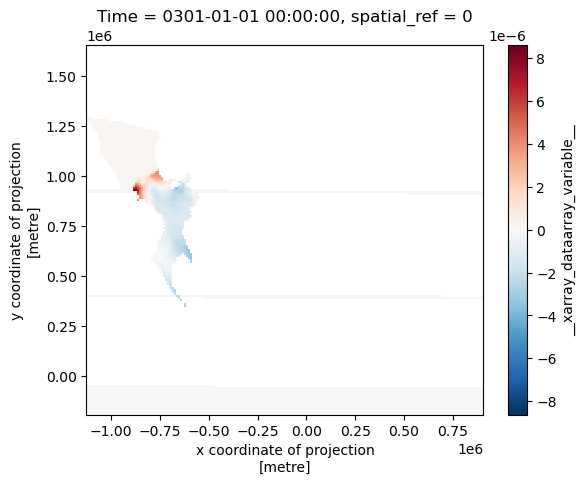

In [40]:
arr[].plot(cm)

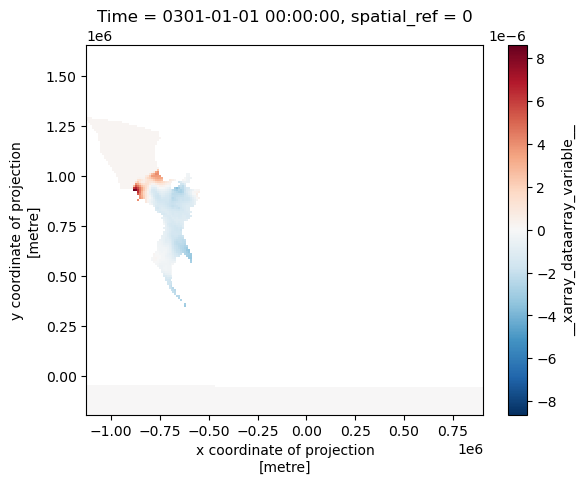

In [22]:
anm_is_slice.plot()

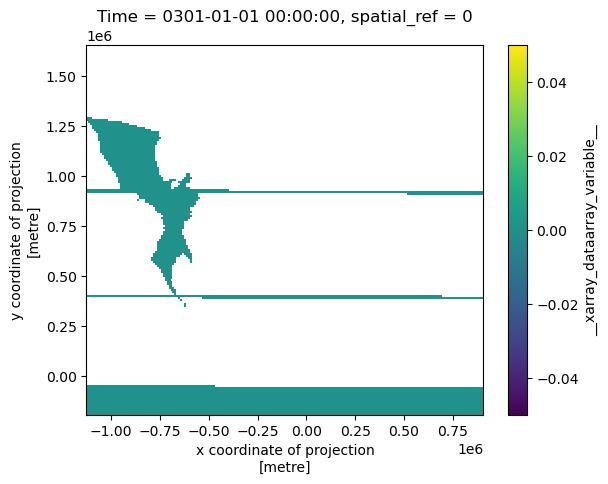

In [41]:
(anm_is_slice-arr).plot()

In [168]:
arrorig

array([[ 1.,  2., nan],
       [nan,  4.,  5.],
       [ 6., nan,  8.]])

In [154]:
nan_indices

array([[0, 2],
       [1, 0],
       [2, 1]])

In [158]:
nearest_idx

array([0, 2])

In [107]:
interp_values = griddata((valid_x, valid_y), valid_values, (x, y), method='nearest')

ValueError: different number of values and points

In [96]:
# slice_2d[~np.isnan(slice_2d)]

valid = slice_2d.notnull()

valid_values = slice_2d[valid[1],valid[0]]

IndexError: Boolean indexer should be unlabeled or on the same dimension to the indexed array. Indexer is on ('x',) but the target dimension is y.

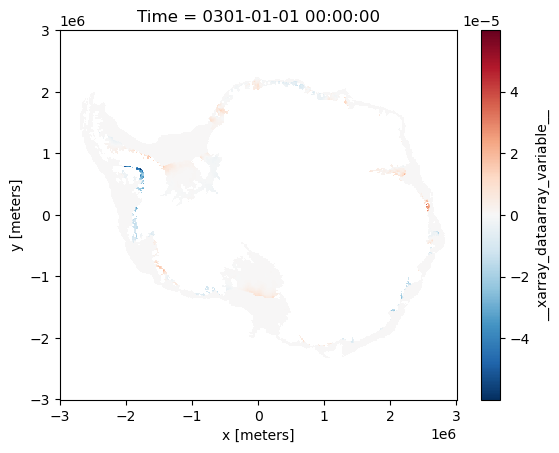